In [ ]:
%load_ext autoreload

In [1]:
import numpy as np
from scipy.stats import itemfreq
import networkx as nx
import pandas as pd

import matplotlib
import seaborn as sns
sns.set_palette('colorblind')
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['font.size'] = 30
matplotlib.rcParams['figure.figsize'] = [8, 6.4]
import random

In [2]:
from toysimulations import Network

In [3]:
import pickle

# read pickled simulation output

In [11]:
PICKLE_FILE = '../data/ring_10.pkl'

with open(PICKLE_FILE, 'rb') as f:
    result = pickle.load(f)

In [12]:
INS_DATA_COLUMNS = ['time', 'stoplist_len', 'stoplist_volume', 'rest_stoplist_volume',
                    'pickup_idx', 'dropoff_idx', 'insertion_type', 'pickup_enroute',
                    'dropoff_enroute']

In [13]:
x_range = np.array(sorted(result.keys()))

In [14]:
x_range[0:10]

array([0.1       , 0.5030303 , 0.90606061, 1.30909091, 1.71212121,
       2.11515152, 2.51818182, 2.92121212, 3.32424242, 3.72727273])

## Time series for $n$, three values of x

In [15]:
len(x_range)

100

In [16]:
x_vals = x_range[0], x_range[2], x_range[9], x_range[30]

#x_vals = x_range[2], x_range[4], x_range[6]


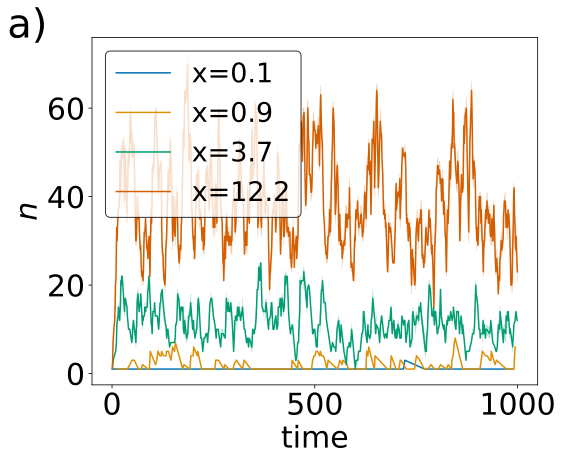

In [17]:
fig, ax = plt.subplots()
t_min, t_max = 0, 1000
for x in x_vals:
    ins_df = pd.DataFrame(result[x]['insertion_data'], 
                          columns = INS_DATA_COLUMNS[:])
    ins_df = ins_df.set_index('time', drop=False)
    sns.lineplot(x='time', y='stoplist_len', data=ins_df.loc[t_min:t_max],\
                 ax = ax, label="x=%.1f"%x)

plt.legend(loc='upper left', framealpha=0.8, fontsize=27, frameon=True, fancybox=True, edgecolor='black')
plt.ylabel(r'$n$')
ax = plt.gca()
plt.text(-0.19, 1, 'a)', fontsize=40, transform=ax.transAxes)

fig.savefig("time_series_ring_10.pdf", bbox_inches='tight')

## Histogram of $t_s$

First, evaluate t_s

In [18]:
req_dfs = {}
G = nx.cycle_graph(10)
nG = Network(G, network_type='ring')

for x in x_range:
    req_df = pd.DataFrame(result[x]['req_data']).T
    req_df.index.name = 'req_idx'
    req_df.loc[:, 'origin'] = req_df.loc[:, 'origin'].astype(int)
    req_df.loc[:, 'destination'] = req_df.loc[:, 'destination'].astype(int)

    req_df['direct_travel_time'] = req_df.apply(
        lambda row:nG.shortest_path_length(int(row['origin']), int(row['destination'])), axis=1)

    req_df['service_time'] = req_df['dropoff_epoch'] - req_df['req_epoch']
    req_df['relative_service_time'] = req_df['service_time']/req_df['direct_travel_time']

    req_dfs[x] = req_df

In [19]:
def x_close_to(x):
    return x_range[np.argmin(np.abs(x_range - x))]

chosen_x_values = [x_close_to(0.2), x_close_to(0.8), x_close_to(1.8)]

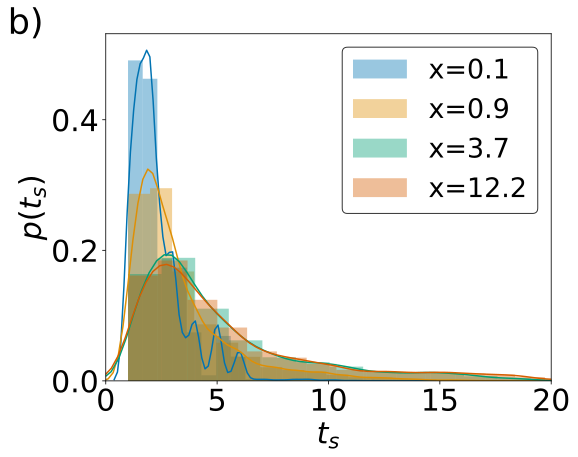

In [20]:
chosen_x_values = x_range[0], x_range[2], x_range[9], x_range[30]

with sns.palettes.color_palette('colorblind'):
    for x in chosen_x_values:
        req_df = req_dfs[x]
    
        sns.distplot(req_df.relative_service_time, hist=True, kde=True,
                 label="x=%.1f"%x, norm_hist=True, bins=20)
    plt.legend(fontsize=27, frameon=True, fancybox=True, edgecolor='black', framealpha=0.8)
    plt.xlabel(r'$t_s$')
    plt.ylabel(r'$p(t_s)$')
    plt.xlim(0, 20)
    ax = plt.gca()
    plt.text(-0.22, 1, 'b)', fontsize=35, transform=ax.transAxes)
    plt.savefig('hist_relative_service_Time_ring10.pdf', bbox_inches='tight')

## Correlation between $t_s$ and $x$

In [21]:
t_s_arr = []
n_arr = []


for x in x_range:
    # compute t_s
    req_df = req_dfs[x]
    
    t_s = np.median(req_df['service_time'])
    
    # compute n
    ins_df = pd.DataFrame(result[x]['insertion_data'], 
                          columns = INS_DATA_COLUMNS[:])
    n = np.median(ins_df['stoplist_len'])
    
    t_s_arr.append(t_s)
    n_arr.append(n)

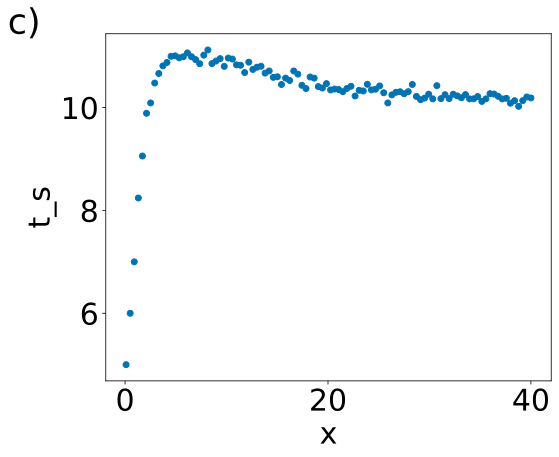

In [22]:
fig, ax = plt.subplots()

x_arr = list(x_range)
ax.scatter(x_arr, t_s_arr)   


ax.set_xlabel('x')
ax.set_ylabel('t_s')


ax.text(-0.22, 1, 'c)', fontsize=35, transform=ax.transAxes)

fig.savefig('corr_ts_x_ring10.pdf', bbox_inches='tight')